<a href="https://colab.research.google.com/github/luisangel181/tesis_ingcivil/blob/main/Absorcion_de_Bloques_de_Concreto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tesis: “RESISTENCIA A LA COMPRESIÓN DE ADOQUINES PARA PAVIMENTOS PEATONALES CON ESCORIA DE SOLDADURA, CAJAMARCA 2024”

Analisis estadistico ANOVA de los resultados de absorción de bloques de concreto

Elaborado por: luis Angel Vásquez Chávez

In [1]:
# librerias a importar
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar archivo de resultados de resistencia a la compresion - cargar hoja "compresion"
df_absorcion = pd.read_excel("/content/drive/MyDrive/RESULTADOS_TESIS CIVIL/Resultados_absorcion.xlsx", sheet_name='Absorcion')

# Visualizar datos
df_absorcion.head()

,Dosificación,Bloque 1,Bloque 2,Bloque 3
0,Patrón,3.58,3.72,3.60
1,5% PE y 0.5% PET,4.26,4.39,4.24
2,10% PE y 0.5% PET,4.51,4.58,4.44
3,15% PE y 0.5% PET,4.64,4.79,4.77


Pruebas de Normalidad

Se Aplica prueba de Shapiro-Wilk para evaluar si los datos siguen uan distribucion de probabilidad normal. Se emplea en muestras pequeñas (<50 datos)

H0: Los datos siguen una distribución normal.

H1: Los datos no siguen una distribución normal.

Si p > 0.05, se acepta H₀ → Los datos son normales (Aplicar ANOVA clásico).

Si p < 0.05, se rechaza H₀ → Los datos no son normales (Aplicar ANOVA no paramétrico).

In [4]:
# Calcular media y desviación estándar para cada dosificación
df_absorcion["Media (%)"] = df_absorcion.iloc[:, 1:4].mean(axis=1)
df_absorcion["Desviación estándar (%)"] = df_absorcion.iloc[:, 1:4].std(axis=1)

# Función para aplicar Shapiro-Wilk y formatear los resultados en tabla
def aplicar_shapiro(data):
    resultados = []
    for i, dosificacion in enumerate(data["Dosificación"]):
        valores = data.iloc[i, 1:4].values
        stat, p = shapiro(valores)
        decision = "Acepta H₀ (Distribución normal)" if p > 0.05 else "Rechaza H₀ (No normal)"
        resultados.append([dosificacion, round(stat, 4), round(p, 4), decision])

    # Imprimir tabla
    print("\nPrueba de Shapiro-Wilk para Absorción (%)")
    print("=" * 60)
    print("{:<25} {:<12} {:<12} {:<25}".format("Dosificación", "Estadístico", "Valor p", "Resultado"))
    print("-" * 60)
    for row in resultados:
        print("{:<25} {:<12} {:<12} {:<25}".format(*row))

# Aplicar la prueba de Shapiro-Wilk
aplicar_shapiro(df_absorcion)

# Aplicar prueba de Levene para homogeneidad de varianzas
valores_absorcion = [df_absorcion.iloc[i, 1:4].values for i in range(len(df_absorcion))]
levene_stat, levene_p = levene(*valores_absorcion, center='mean') #mean, median, trimmed , default es "median", Se ajusta distribucion normal == mean

# Mostrar resultados de Levene
print("\nPrueba de Levene para Homogeneidad de Varianzas")
print("=" * 60)
print("Estadístico: {:.4f}  |  Valor p: {:.4f}".format(levene_stat, levene_p))
decision_levene = "Acepta H₀ (Varianzas homogéneas)" if levene_p > 0.05 else "Rechaza H₀ (Varianzas no homogéneas)"
print("Resultado: {}\n".format(decision_levene))

df_absorcion[["Dosificación", "Media (%)", "Desviación estándar (%)"]]


Prueba de Shapiro-Wilk para Absorción (%)
Dosificación              Estadístico  Valor p      Resultado                
------------------------------------------------------------
Patrón                    0.8547       0.253        Acepta H₀ (Distribución normal)
5% PE y 0.5% PET          0.848        0.2351       Acepta H₀ (Distribución normal)
10% PE y 0.5% PET         1.0          1.0          Acepta H₀ (Distribución normal)
15% PE y 0.5% PET         0.848        0.2351       Acepta H₀ (Distribución normal)

Prueba de Levene para Homogeneidad de Varianzas
Estadístico: 0.1613  |  Valor p: 0.9194
Resultado: Acepta H₀ (Varianzas homogéneas)



,Dosificación,Media (%),Desviación estándar (%)
0,Patrón,3.633333,0.075719
1,5% PE y 0.5% PET,4.296667,0.081445
2,10% PE y 0.5% PET,4.510000,0.070000
3,15% PE y 0.5% PET,4.733333,0.081445


Aplicando prueba ANOVA

Hipotesis nula (H0): "La adición de poliestireno expandido (PE) y fibras de PET no influye significativamente en absorción del bloque de concreto."

Hipotesis alternativa (H1): "La adición de poliestireno expandido (PE) y fibras de PET influye significativamente en la absorción del bloque de concreto."

In [10]:
# Definir función para aplicar ANOVA clásico o ANOVA de Welch según homogeneidad

def aplicar_anova(data, homogeneidad):
    modelo = ols('Absorción ~ C(Dosificación)', data=data).fit()
    if homogeneidad:
        anova = sm.stats.anova_lm(modelo, typ=2)  # ANOVA clásico
    else:
        anova = sm.stats.anova_lm(modelo, typ=2, robust='hc3')  # ANOVA de Welch
    return anova

# Reestructurar el DataFrame para incluir valores individuales por bloque
df_long_absorcion = df_absorcion.melt(id_vars=['Dosificación'],
                                      value_vars=['Bloque 1', 'Bloque 2', 'Bloque 3'],
                                      var_name='Bloque', value_name='Absorción')

# Aplicar ANOVA para absorción (usar ANOVA clásico porque Levene lo aceptó)
homogeneo = True
tipo_anova = 'Clasico' if homogeneo else 'de Welch'
anova_absorcion = aplicar_anova(df_long_absorcion, homogeneidad=homogeneo)

# Extraer valores clave del ANOVA
p_valor = anova_absorcion.iloc[0]["PR(>F)"]
F_valor = anova_absorcion.iloc[0]["F"]

print(f"\n ANOVA {tipo_anova}:")
print("=" * 50)
print(anova_absorcion)

# Interpretación del resultado
if p_valor < 0.05:
    print("Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la absorción de agua entre las diferentes dosificaciones de bloques de concreto.")
    print(f"Valor p: {p_valor:.6f}")
    print(f"Estadístico F: {F_valor:.4f}")
    print("Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.")
else:
    print("No se rechaza la hipótesis nula, lo que indica que no hay diferencias significativas en la absorción de agua entre las diferentes dosificaciones.")

# Mostrar resultados de ANOVA
print("Resultados completos de ANOVA para Absorción:")

anova_absorcion



 ANOVA Clasico:
                   sum_sq   df          F        PR(>F)
C(Dosificación)  2.028467  3.0  113.16411  6.849237e-07
Residual         0.047800  8.0        NaN           NaN
Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la absorción de agua entre las diferentes dosificaciones de bloques de concreto.
Valor p: 0.000001
Estadístico F: 113.1641
Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.
Resultados completos de ANOVA para Absorción:


,sum_sq,df,F,PR(>F)
C(Dosificación),2.028467,3.0,113.16411,6.849237e-07
Residual,0.047800,8.0,NaN,NaN


In [6]:
# Aplicar la prueba de Tukey para Absorción
tukey_absorcion = pairwise_tukeyhsd(endog=df_long_absorcion['Absorción'],
                                    groups=df_long_absorcion['Dosificación'],
                                    alpha=0.05)

# Mostrar resultados
print("Prueba de Tukey para Absorción (%)")
print("=" * 60)
print(tukey_absorcion)

Prueba de Tukey para Absorción (%)
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
10% PE y 0.5% PET 15% PE y 0.5% PET   0.2233 0.0313  0.0212  0.4254   True
10% PE y 0.5% PET  5% PE y 0.5% PET  -0.2133  0.039 -0.4154 -0.0112   True
10% PE y 0.5% PET            Patrón  -0.8767    0.0 -1.0788 -0.6746   True
15% PE y 0.5% PET  5% PE y 0.5% PET  -0.4367 0.0006 -0.6388 -0.2346   True
15% PE y 0.5% PET            Patrón     -1.1    0.0 -1.3021 -0.8979   True
 5% PE y 0.5% PET            Patrón  -0.6633    0.0 -0.8654 -0.4612   True
--------------------------------------------------------------------------


<ipython-input-14-963a1e765e37>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dosificación', y='Absorción', data=df_long_absorcion, palette="Set2")


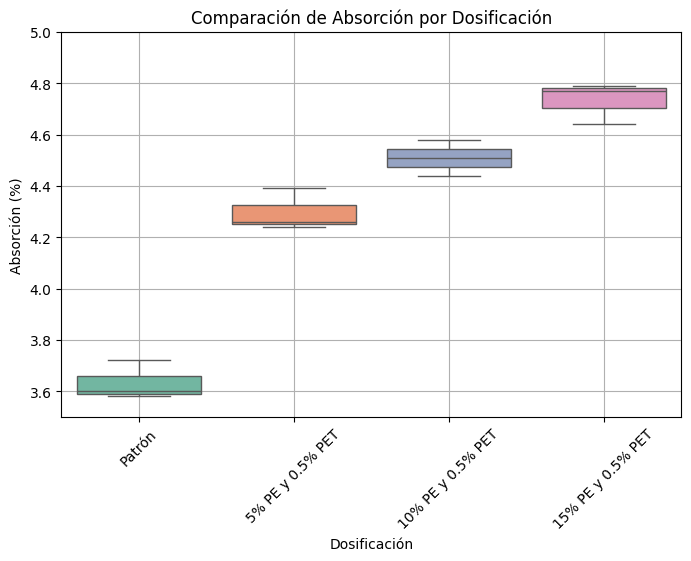

In [14]:
#Graficar Resultados

# Crear el gráfico de comparación de absorción
plt.figure(figsize=(8, 5))
sns.boxplot(x='Dosificación', y='Absorción', data=df_long_absorcion, palette="Set2")

# Ajustar los límites del eje y
plt.ylim(3.5, 5)

# Personalizar el gráfico
plt.title('Comparación de Absorción por Dosificación')
plt.xlabel('Dosificación')
plt.ylabel('Absorción (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
